In [1]:
# Import basic modules
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from scipy.stats import norm

# Import regression and error metrics modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import pandas as pd

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('bmh')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
path = r'C:\Users\xiand\Desktop\PropTech Challenge 2020\PropTech Challenge 2020 Data'
electric = pd.read_excel(path + '\ConEd_Electric.xlsx')
electric['date_time'] = pd.to_datetime(electric['date_time'])
date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-09-01', freq='15T'), columns=['date_time'])
electric = pd.merge(date_time, electric, on='date_time', how='left')
electric = electric.drop(['min_demand', 'avg_demand'], axis=1).rename(columns={'max_demand': 'demand'})
electric['cum_consumption'] = electric['consumption'].fillna(0).cumsum()

steam = pd.read_excel(path + '\ConEd_Steam.xlsx')
steam['date_time'] = pd.to_datetime(steam['date_time'])
steam = pd.merge(date_time, steam, on='date_time', how='left')
steam = steam.drop(['min_demand', 'avg_demand'], axis=1).rename(columns={'max_demand': 'demand'})
steam['cum_consumption'] = steam['consumption'].fillna(0).cumsum()
steam['temp'] = steam['temp'].interpolate(limit_direction='both')
steam['humidity'] = steam['humidity'].interpolate(limit_direction='both')

occupancy = pd.read_excel(path + '\Occupancy.xlsx')
date = pd.DataFrame(pd.date_range('2020-02-10', '2020-08-31'), columns=['date'])
occupancy = pd.merge(date, occupancy, on='date', how='left')

In [3]:
tenant_usage = pd.ExcelFile(path + '\Tenant_Usage.xlsx')

tenant_usage_meters = tenant_usage.parse('Meters')
tenant_usage_meters['Floor'] = tenant_usage_meters['Location'].str.extract('(\d+)')
tenant_usage_meters['Direction'] = tenant_usage_meters['Location'].apply(lambda x: 'South' if 'South' in x else 'North' if 'North' in x else '')
tenant_usage_meters['Other'] = tenant_usage_meters['Location'].apply(lambda x: 'HP' if 'HP' in x else 'LP' if 'LP' in x else 'LVP' if 'LVP' in x else '')


tenants = []
for i in range(1, 19):
    df = tenant_usage.parse(tenant_usage.sheet_names[i])
    df['date_time'] = pd.to_datetime(df['date_time'])
    date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-08-30 23:45:00', freq='15T'), columns=['date_time'])
    df = pd.merge(date_time, df, on='date_time', how='left')
    df['consumption'] = df['consumption'].abs()
    df = df.drop(['min_demand', 'avg_demand'], axis=1).rename(columns={'max_demand': 'demand'})
    df['cum_consumption'] = df['consumption'].fillna(0).cumsum()
    tenants.append(df)

In [28]:
merge_data = electric.rename(columns={'consumption': 'electric_consumption', 'cum_consumption': 'electric_cum_consumption', 'demand': 'electric_demand'}).drop(['temp', 'humidity'], axis=1) \
            .merge(steam.rename(columns={'consumption': 'steam_consumption', 'cum_consumption': 'steam_cum_consumption', 'demand': 'steam_demand'}), on='date_time', how='outer') 
for i in range(18):
    merge_data = merge_data.merge(tenants[i].rename(columns={'consumption': 'tenant_'+str(i+1)+'_consumption', 'cum_consumption': 'tenant_'+str(i+1)+'_cum_consumption', 'demand': 'tenant_'+str(i+1)+'_demand'}).drop('meter', axis=1), 
                                  on='date_time', how='outer')
merge_data['date'] = pd.to_datetime(merge_data['date_time'].dt.strftime('%Y-%m-%d'))
merge_data = merge_data.merge(occupancy, on='date', how='outer')

merge_data

,date_time,electric_consumption,electric_demand,electric_cum_consumption,steam_consumption,steam_demand,temp,humidity,steam_cum_consumption,tenant_1_consumption,...,tenant_16_demand,tenant_16_cum_consumption,tenant_17_consumption,tenant_17_demand,tenant_17_cum_consumption,tenant_18_consumption,tenant_18_demand,tenant_18_cum_consumption,date,entries
0,2018-01-01 00:15:00,430.0,1720.0,430.0,4800.0,18700.0,9.000,56.100,4800.0,0.4,...,0.6,0.2,0.2,1.2,0.2,0.0,0.0,0.0,2018-01-01,NaN
1,2018-01-01 00:30:00,420.0,1700.0,850.0,4480.0,18560.0,9.000,56.100,9280.0,0.4,...,0.6,0.3,0.2,0.8,0.4,0.0,0.0,0.0,2018-01-01,NaN
2,2018-01-01 00:45:00,440.0,1720.0,1290.0,5350.0,19660.0,9.000,56.100,14630.0,0.4,...,0.6,0.5,0.4,1.2,0.8,0.2,0.4,0.2,2018-01-01,NaN
3,2018-01-01 01:00:00,420.0,1720.0,1710.0,5660.0,22020.0,9.000,56.100,20290.0,0.3,...,0.6,0.6,0.4,1.6,1.2,0.0,0.4,0.2,2018-01-01,NaN
4,2018-01-01 01:15:00,420.0,1680.0,2130.0,5660.0,22640.0,8.975,56.125,25950.0,0.4,...,0.6,0.8,0.2,1.2,1.4,0.0,0.0,0.2,2018-01-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93499,2020-08-31 23:00:00,200.0,800.0,32642490.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31,234.0
93500,2020-08-31 23:15:00,200.0,800.0,32642690.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31,234.0
93501,2020-08-31 23:30:00,200.0,800.0,32642890.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31,234.0
93502,2020-08-31 23:45:00,200.0,800.0,32643090.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31,234.0


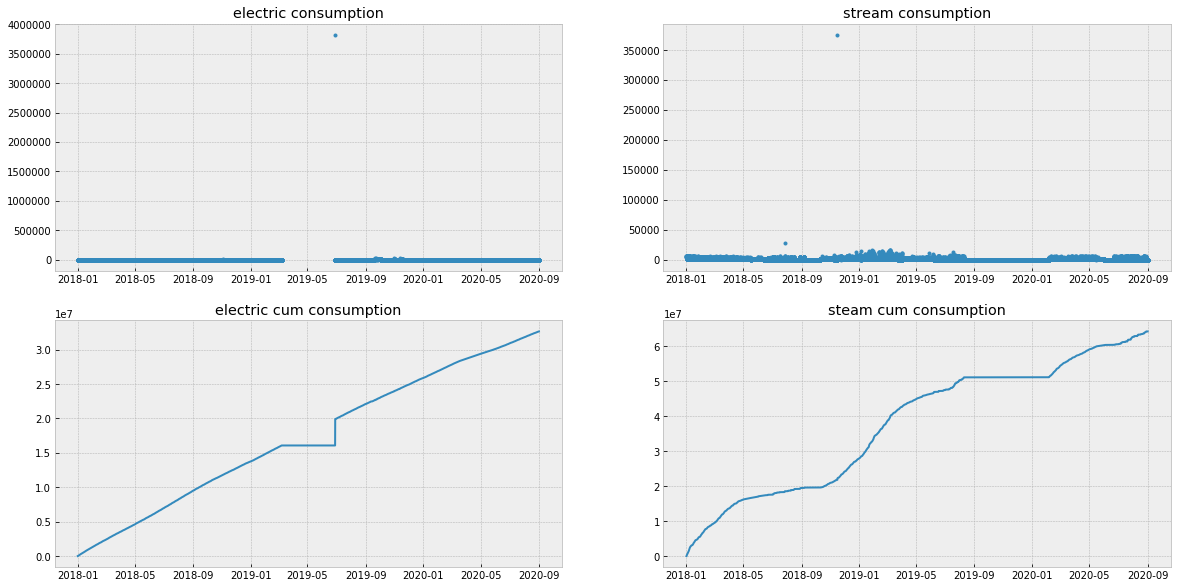

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(merge_data['date_time'], merge_data['electric_consumption'], '.')
axs[0, 0].set_title('electric consumption')
axs[0, 1].plot(merge_data['date_time'], merge_data['steam_consumption'], '.')
axs[0, 1].set_title('stream consumption')
axs[1, 0].plot(merge_data['date_time'], merge_data['electric_cum_consumption'], '-')
axs[1, 0].set_title('electric cum consumption')
axs[1, 1].plot(merge_data['date_time'], merge_data['steam_cum_consumption'], '-')
axs[1, 1].set_title('steam cum consumption')
plt.show()

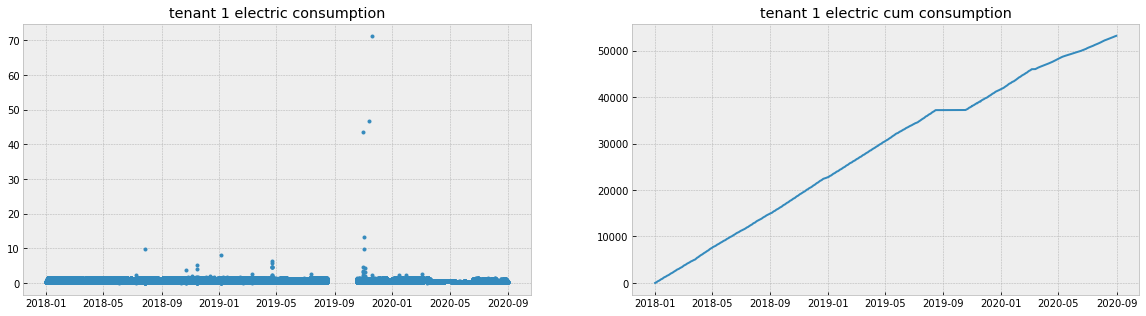

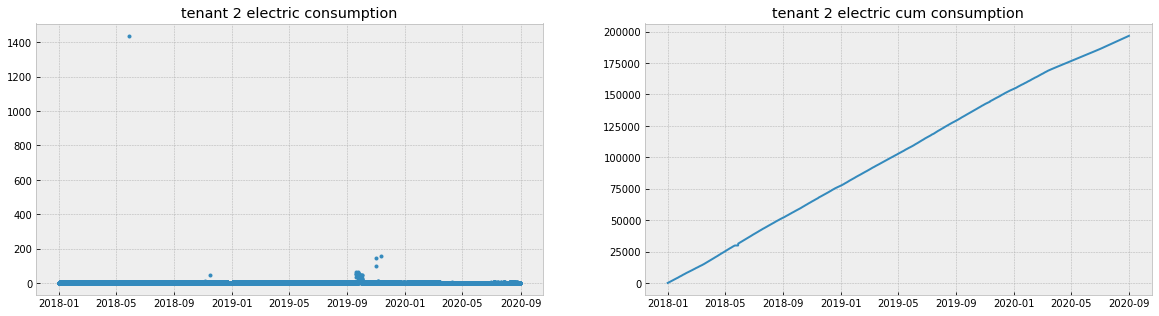

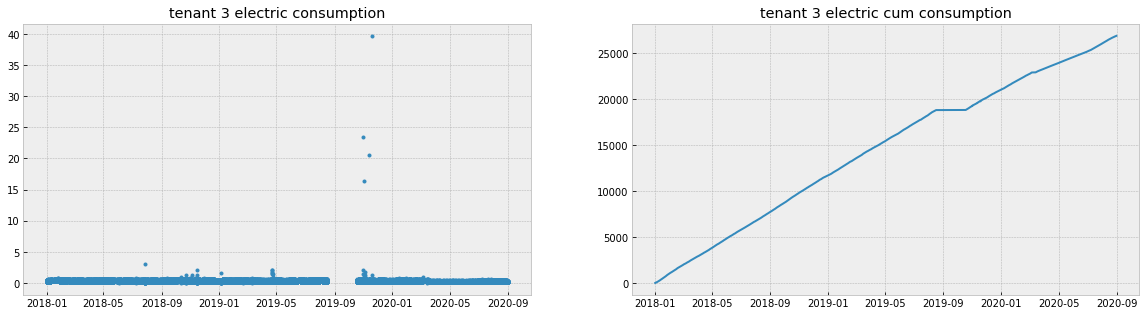

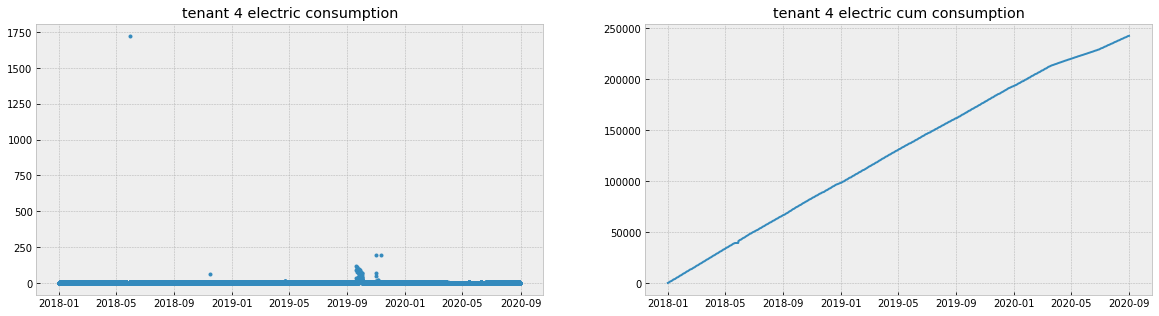

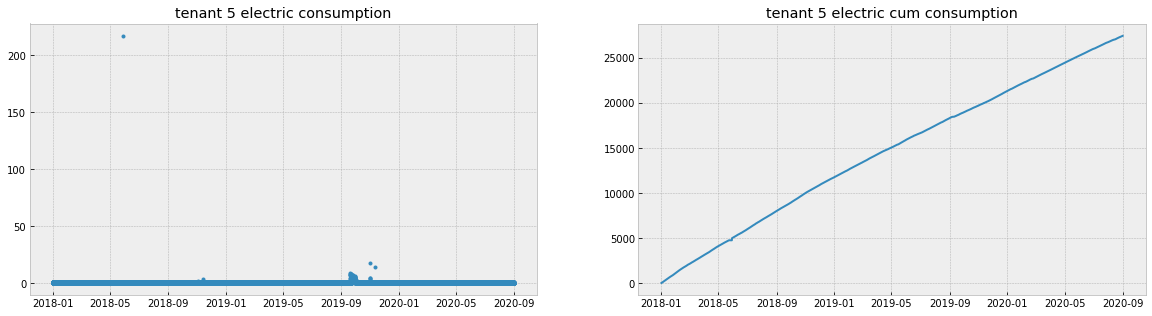

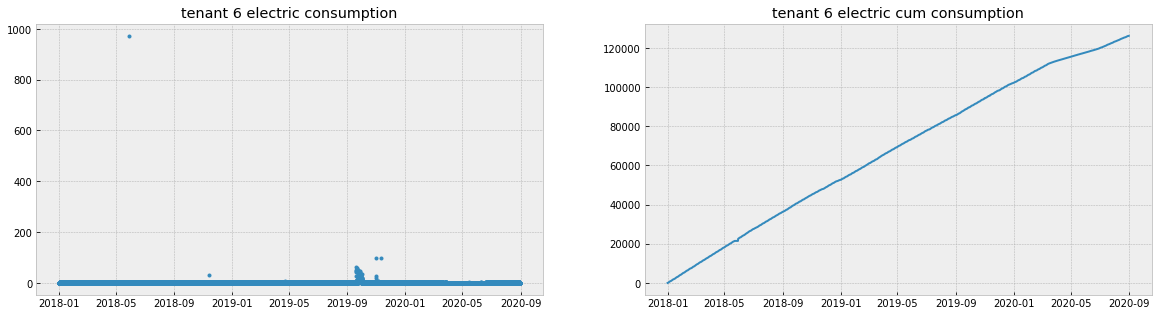

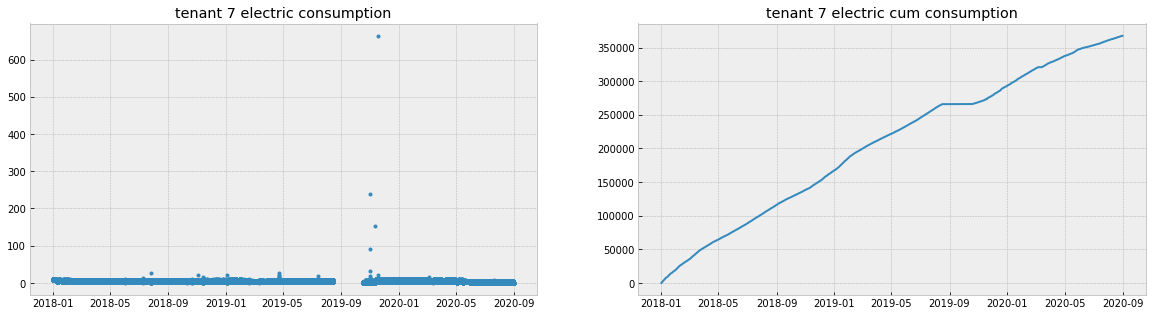

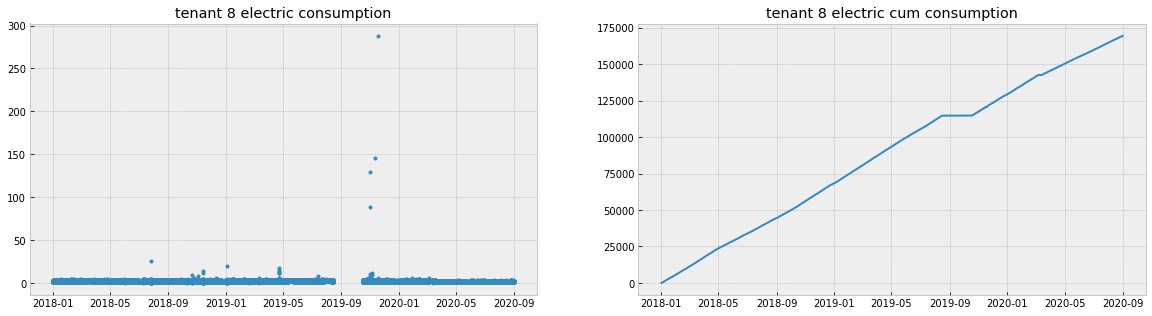

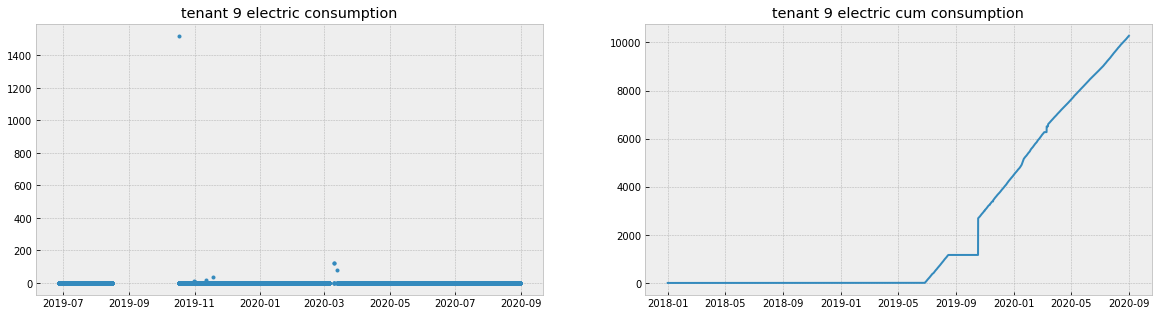

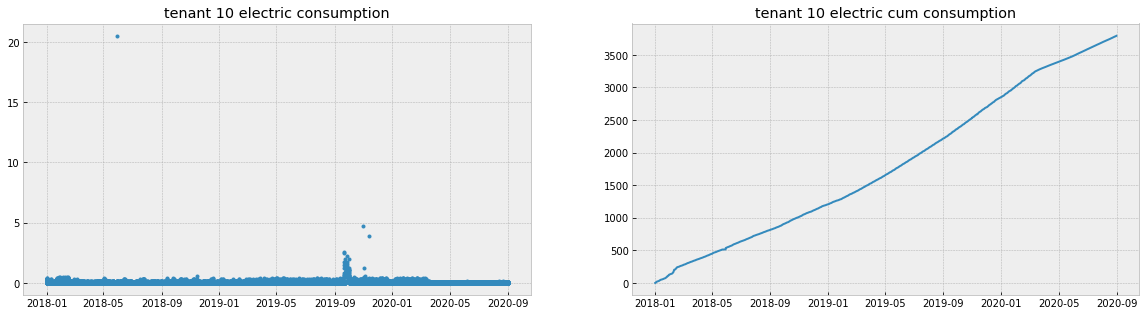

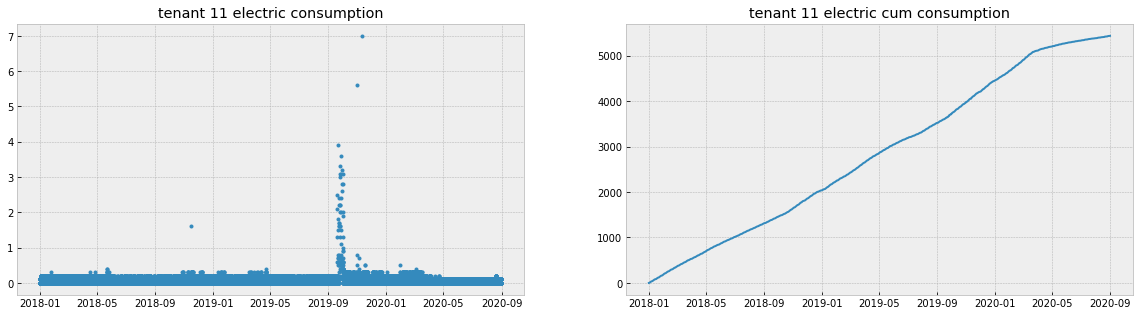

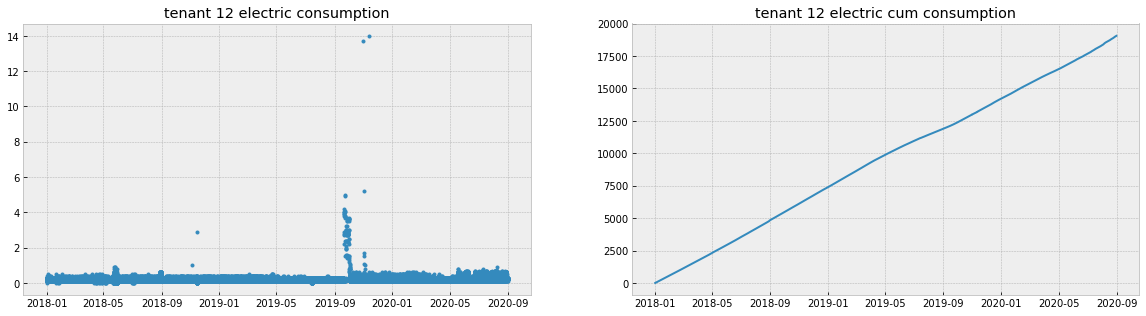

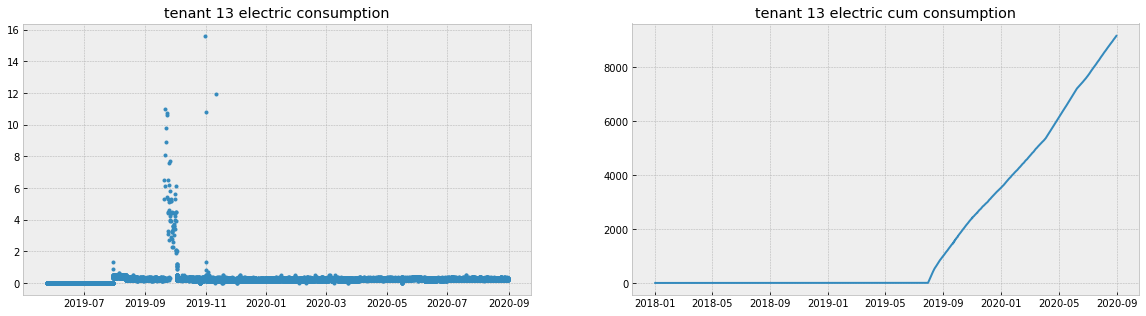

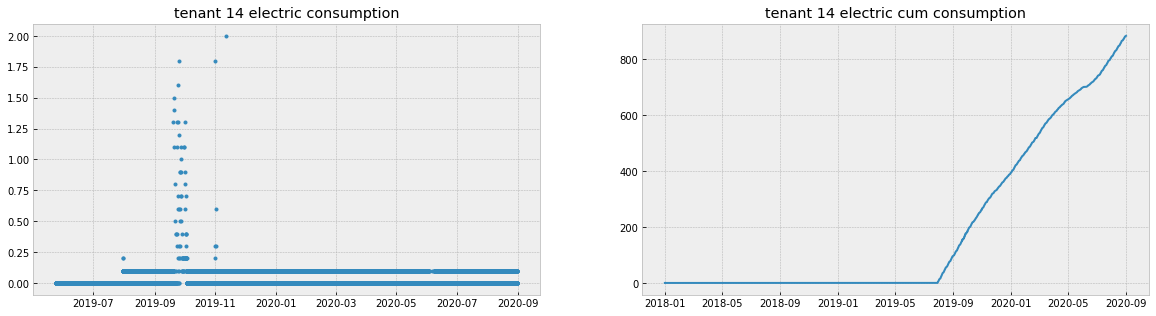

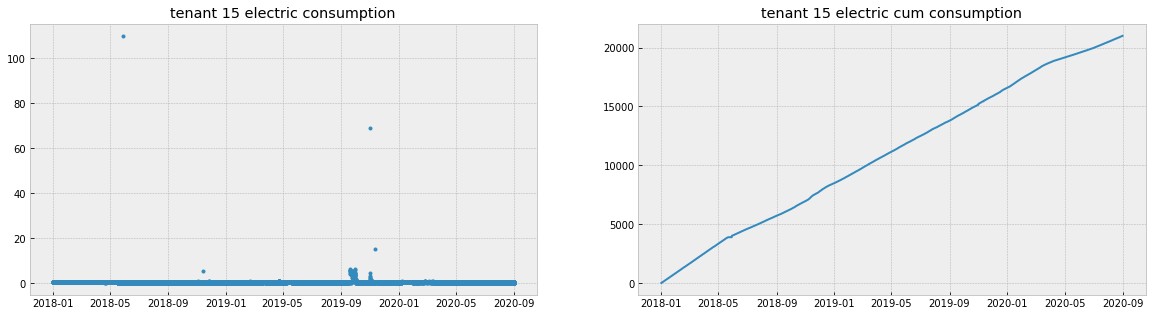

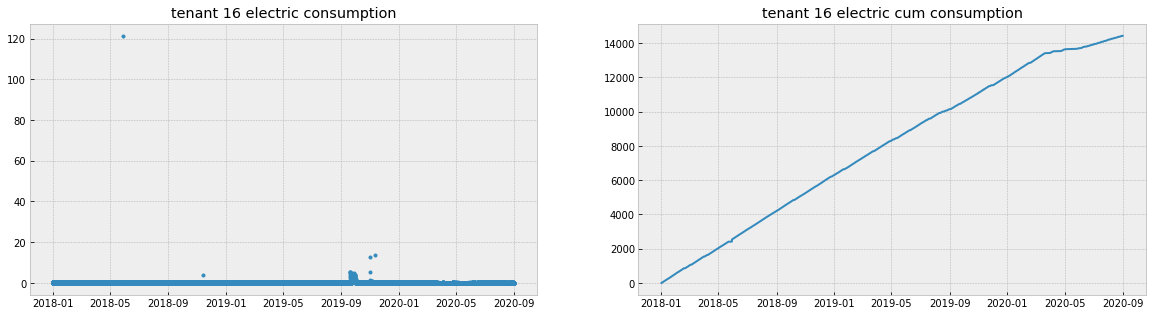

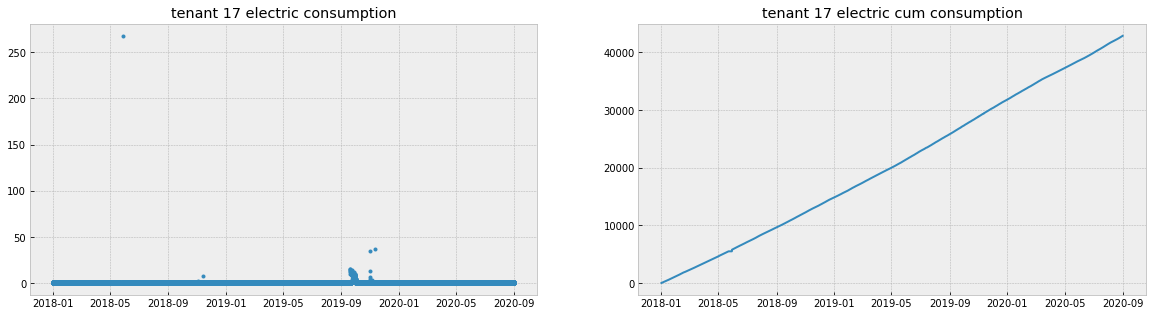

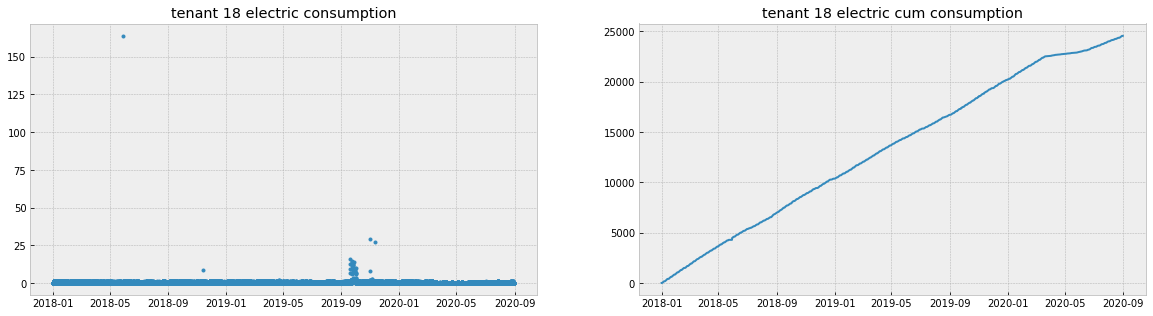

In [30]:
for i in range(1,19):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    ax1.plot(merge_data['date_time'], merge_data['tenant_'+str(i)+'_consumption'], '.')
    ax1.set_title('tenant '+str(i)+' electric consumption')
    ax2.plot(merge_data['date_time'], merge_data['tenant_'+str(i)+'_cum_consumption'], '-')
    ax2.set_title('tenant '+str(i)+' electric cum consumption')

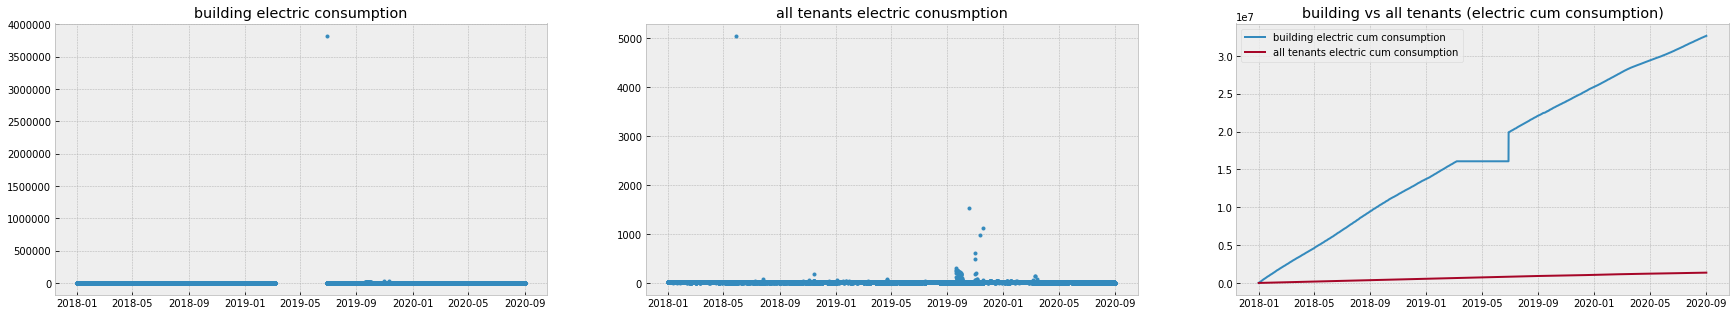

In [31]:
merge_data['all_tenants_consumption'] = 0
for i in range(1, 19):
    merge_data['all_tenants_consumption'] = merge_data['all_tenants_consumption'] + merge_data['tenant_'+str(i)+'_consumption'].fillna(0)
merge_data['all_tenants_cum_consumption'] = merge_data['all_tenants_consumption'].fillna(0).cumsum()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,5))
ax1.plot(merge_data['date_time'], merge_data['electric_consumption'], '.')
ax1.set_title('building electric consumption')
ax2.plot(merge_data['date_time'], merge_data['all_tenants_consumption'], '.')
ax2.set_title('all tenants electric conusmption')
ax3.plot(merge_data['date_time'], merge_data['electric_cum_consumption'], '-', label='building electric cum consumption')
ax3.plot(merge_data['date_time'], merge_data['all_tenants_cum_consumption'], '-', label='all tenants electric cum consumption')
ax3.set_title('building vs all tenants (electric cum consumption)')
ax3.legend()

plt.show()

In [32]:
merge_data['date'] = pd.to_datetime(merge_data['date_time'].dt.strftime('%Y-%m-%d'))
daily_consumption = merge_data.groupby(['date'])['electric_consumption', 'steam_consumption', 'all_tenants_consumption'].sum().reset_index()
daily_consumption = occupancy.merge(daily_consumption, on='date', how='outer')
daily_consumption

,date,entries,electric_consumption,steam_consumption,all_tenants_consumption
0,2020-02-10,1900.0,36720.0,179360.0,1815.9
1,2020-02-11,NaN,35640.0,129380.0,1685.4
2,2020-02-12,NaN,36160.0,149670.0,1760.6
3,2020-02-13,NaN,35640.0,154400.0,1750.6
4,2020-02-14,NaN,36080.0,206430.0,1778.3
...,...,...,...,...,...
970,2020-02-06,NaN,35820.0,161590.0,1790.9
971,2020-02-07,NaN,35920.0,166620.0,1815.8
972,2020-02-08,NaN,25120.0,72200.0,974.5
973,2020-02-09,NaN,24380.0,65260.0,966.0


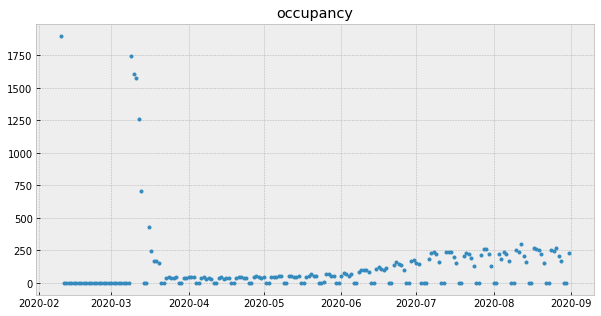

In [33]:
plt.figure(figsize=(10,5))
plt.plot(occupancy['date'], occupancy['entries'].fillna(0), '.')
plt.title('occupancy')
plt.show()

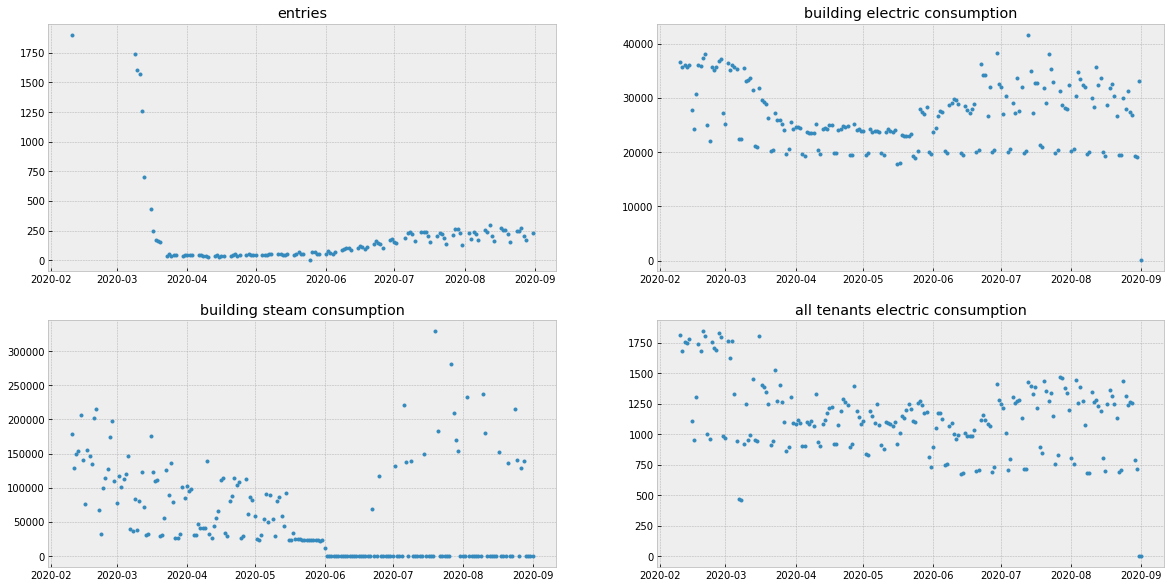

In [34]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
df = daily_consumption[daily_consumption['date'].dt.strftime('%Y-%m-%d')>='2020-02-10']

axs[0,0].plot(df['date'], df['entries'], '.')
axs[0,0].set_title('entries')
axs[0,1].plot(df['date'], df['electric_consumption'], '.')
axs[0,1].set_title('building electric consumption')
axs[1,0].plot(df['date'], df['steam_consumption'], '.')
axs[1,0].set_title('building steam consumption')
axs[1,1].plot(df['date'], df['all_tenants_consumption'], '.')
axs[1,1].set_title('all tenants electric consumption')
plt.show()

In [35]:
# not fillna
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,entries,electric_consumption,steam_consumption,all_tenants_consumption
entries,1,0.485252,0.155694,0.130857
electric_consumption,0.485252,1,0.347356,0.732743
steam_consumption,0.155694,0.347356,1,0.604977
all_tenants_consumption,0.130857,0.732743,0.604977,1


In [36]:
# fillna
corr = df.fillna(0).corr()
corr.style.background_gradient(cmap='coolwarm')

,entries,electric_consumption,steam_consumption,all_tenants_consumption
entries,1,0.371375,0.157511,0.162399
electric_consumption,0.371375,1,0.347356,0.732743
steam_consumption,0.157511,0.347356,1,0.604977
all_tenants_consumption,0.162399,0.732743,0.604977,1


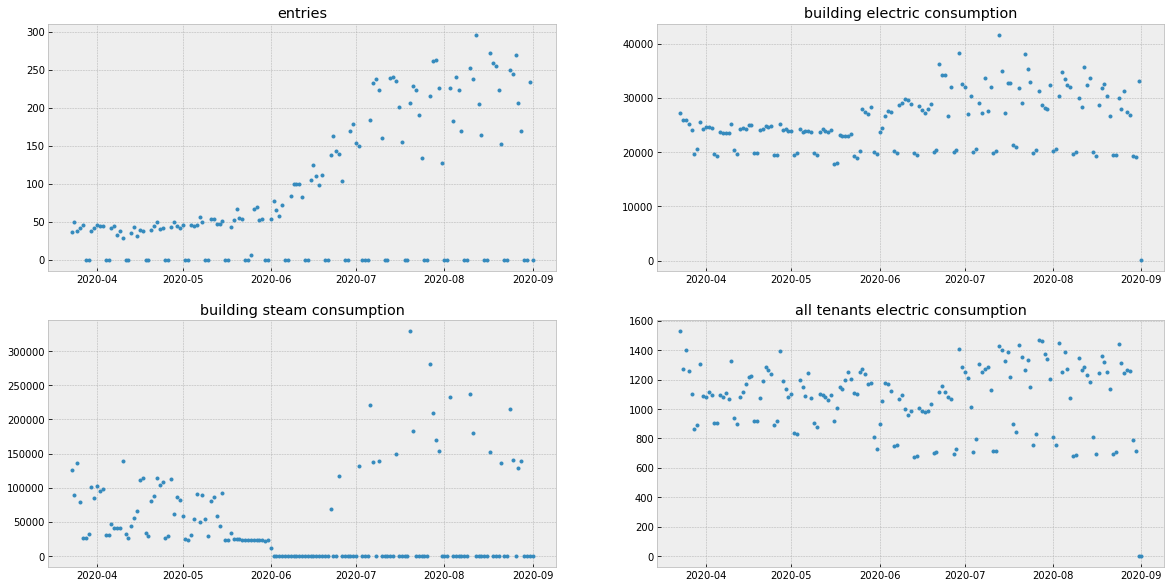

,entries,electric_consumption,steam_consumption,all_tenants_consumption
entries,1,0.80084,0.349631,0.593255
electric_consumption,0.80084,1,0.121995,0.663854
steam_consumption,0.349631,0.121995,1,0.507951
all_tenants_consumption,0.593255,0.663854,0.507951,1


In [37]:
# shorten date range
fig, axs = plt.subplots(2,2, figsize=(20,10))
df = daily_consumption[daily_consumption['date'].dt.strftime('%Y-%m-%d')>='2020-03-23']

axs[0,0].plot(df['date'], df['entries'].fillna(0), '.')
axs[0,0].set_title('entries')
axs[0,1].plot(df['date'], df['electric_consumption'], '.')
axs[0,1].set_title('building electric consumption')
axs[1,0].plot(df['date'], df['steam_consumption'], '.')
axs[1,0].set_title('building steam consumption')
axs[1,1].plot(df['date'], df['all_tenants_consumption'], '.')
axs[1,1].set_title('all tenants electric consumption')
plt.show()

corr = df.fillna(0).corr()
corr.style.background_gradient(cmap='coolwarm')

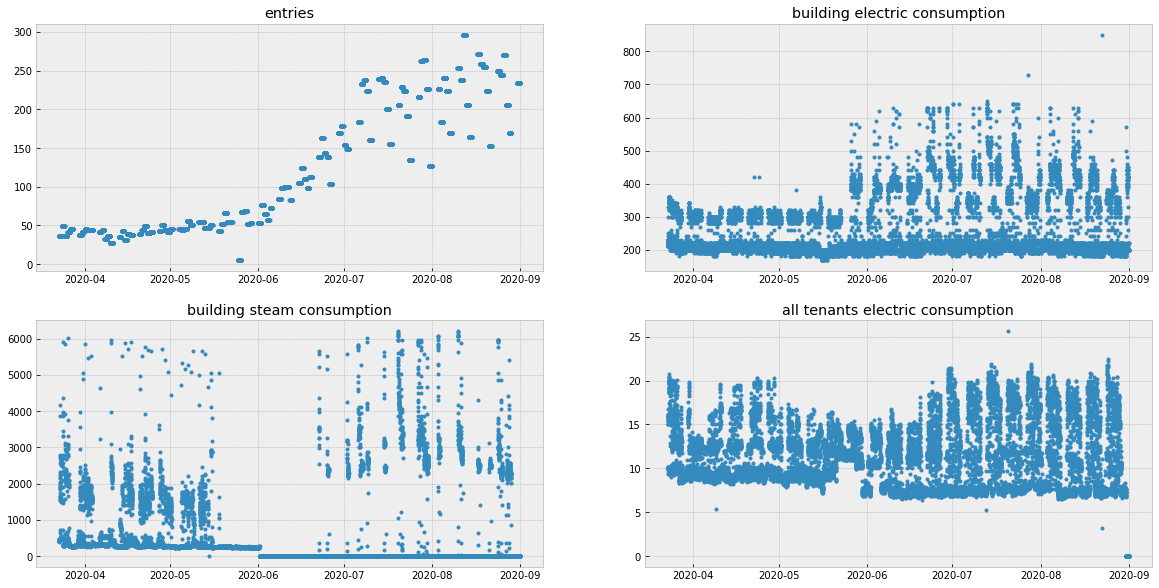

,entries,electric_consumption,steam_consumption,all_tenants_consumption
entries,1,0.490371,0.238994,0.396837
electric_consumption,0.490371,1,0.228201,0.622057
steam_consumption,0.238994,0.228201,1,0.414882
all_tenants_consumption,0.396837,0.622057,0.414882,1


In [38]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
df = merge_data[merge_data['date'].dt.strftime('%Y-%m-%d')>='2020-03-23'][['date_time', 'entries', 'electric_consumption', 'steam_consumption', 'all_tenants_consumption']]

axs[0,0].plot(df['date_time'], df['entries'], '.')
axs[0,0].set_title('entries')
axs[0,1].plot(df['date_time'], df['electric_consumption'], '.')
axs[0,1].set_title('building electric consumption')
axs[1,0].plot(df['date_time'], df['steam_consumption'], '.')
axs[1,0].set_title('building steam consumption')
axs[1,1].plot(df['date_time'], df['all_tenants_consumption'], '.')
axs[1,1].set_title('all tenants electric consumption')
plt.show()

corr = df.fillna(0).corr()
corr.style.background_gradient(cmap='coolwarm')

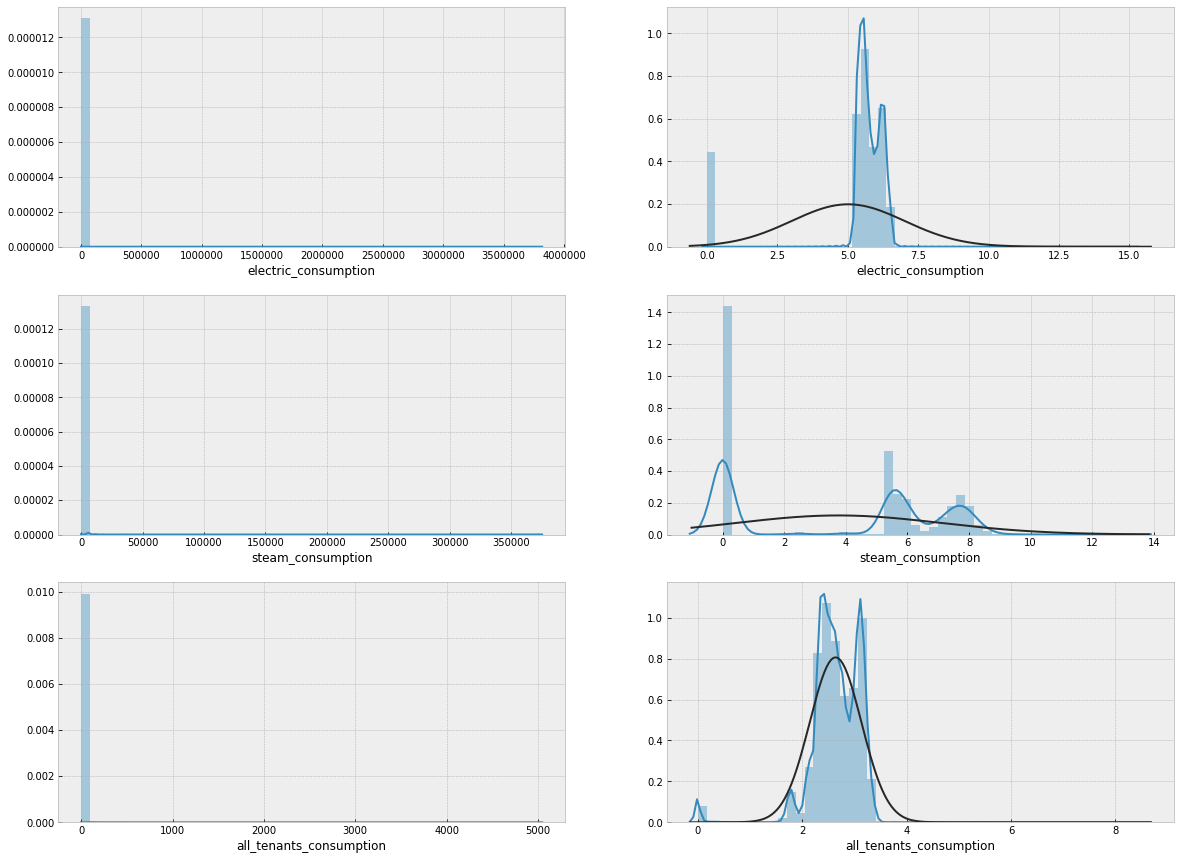

In [39]:
fig, axs = plt.subplots(3,2, figsize=(20,15))
sns.distplot(merge_data['electric_consumption'].fillna(0), ax=axs[0, 0])
sns.distplot(np.log1p(merge_data['electric_consumption'].fillna(0)), fit=norm, ax=axs[0, 1])
sns.distplot(merge_data['steam_consumption'].fillna(0), ax=axs[1, 0])
sns.distplot(np.log1p(merge_data['steam_consumption'].fillna(0)), fit=norm, ax=axs[1, 1])
sns.distplot(merge_data['all_tenants_consumption'].fillna(0), ax=axs[2, 0])
sns.distplot(np.log1p(merge_data['all_tenants_consumption'].fillna(0)), fit=norm, ax=axs[2, 1])
plt.show()

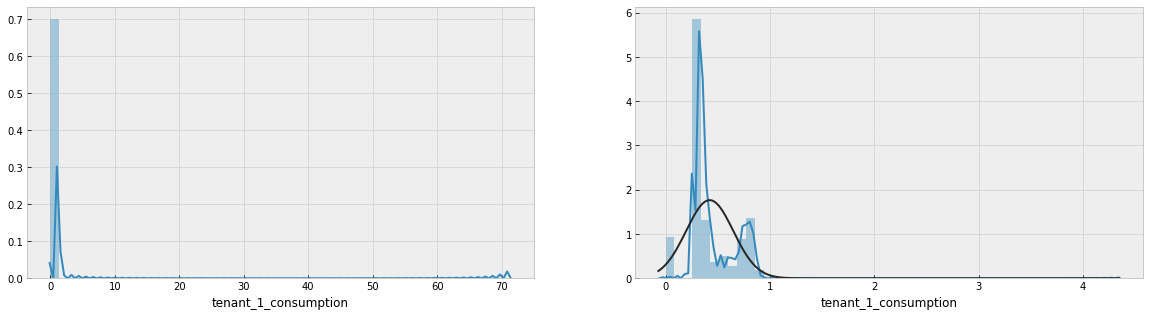

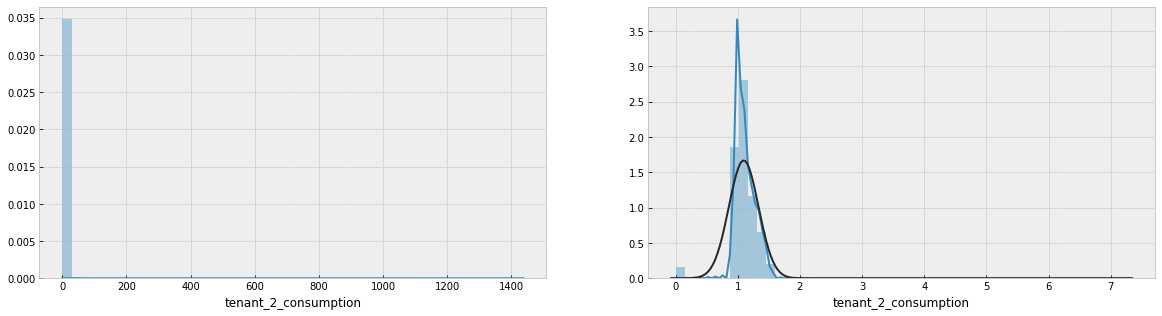

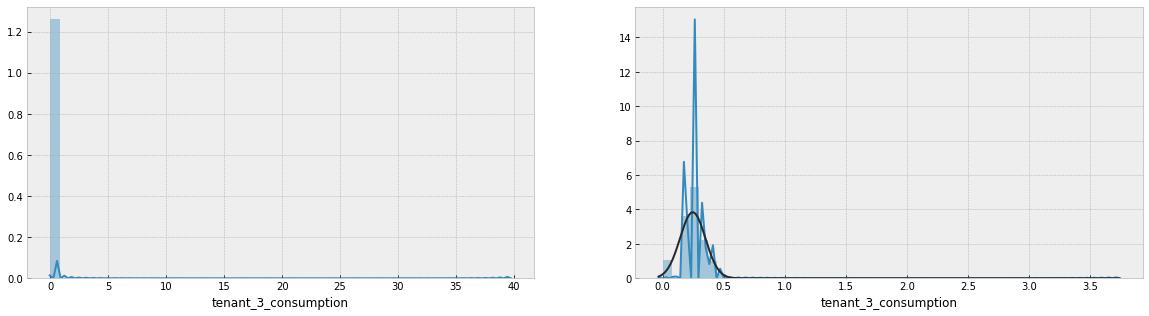

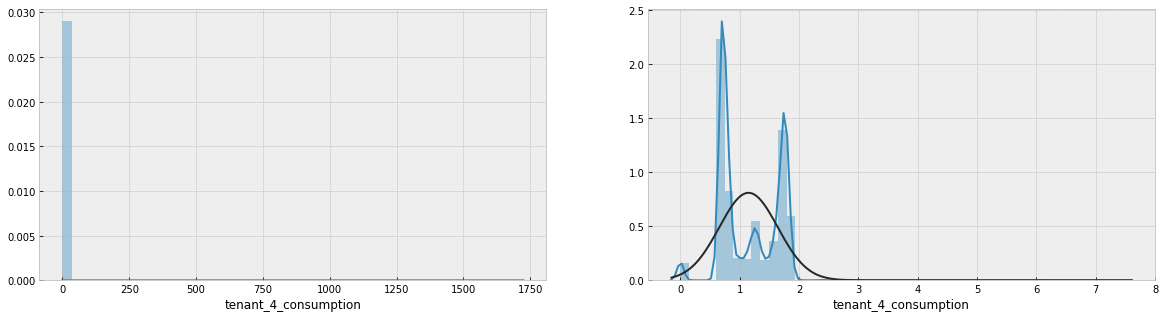

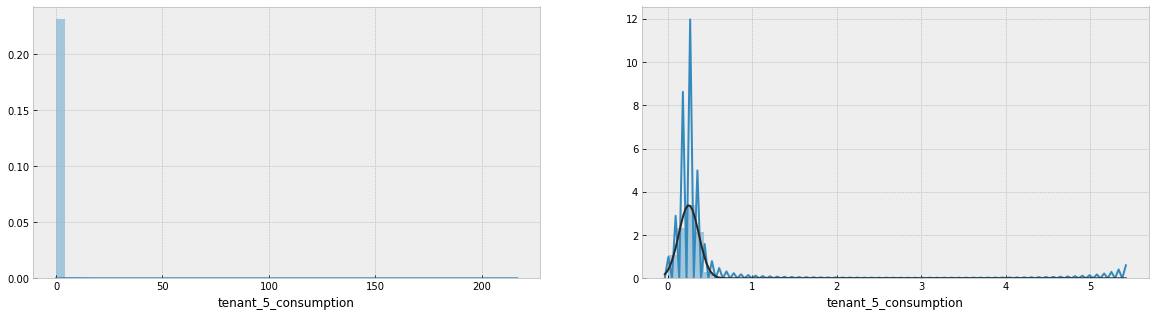

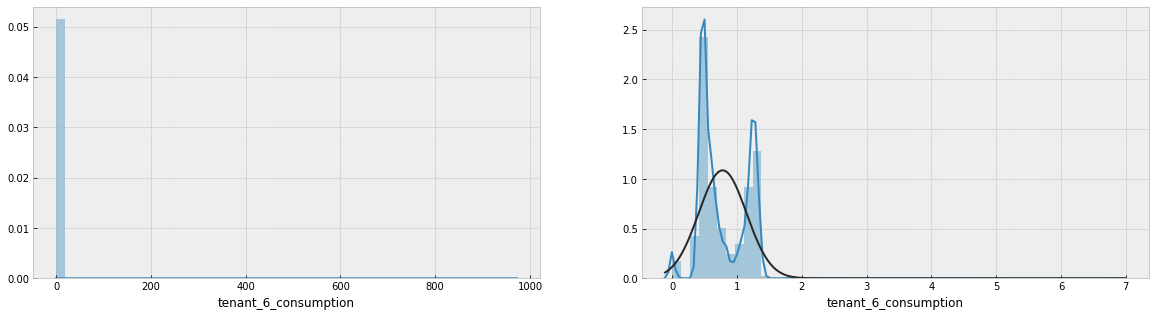

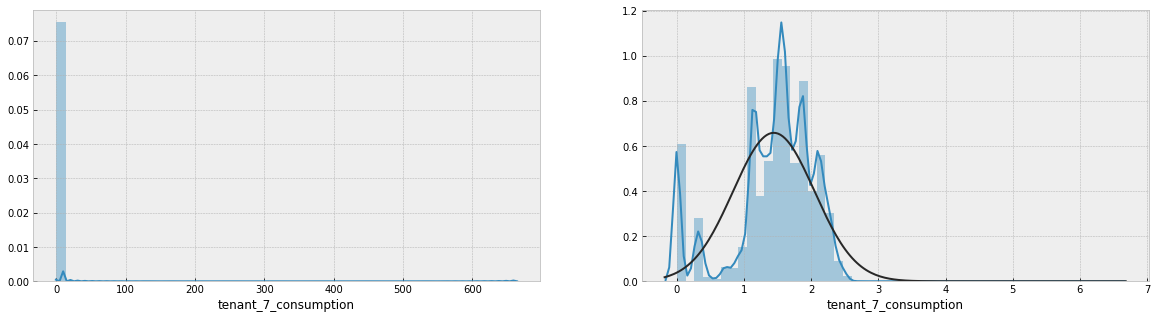

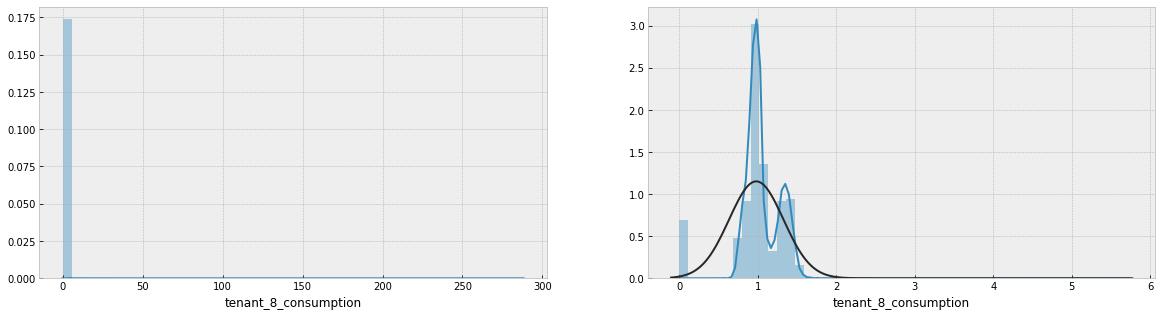

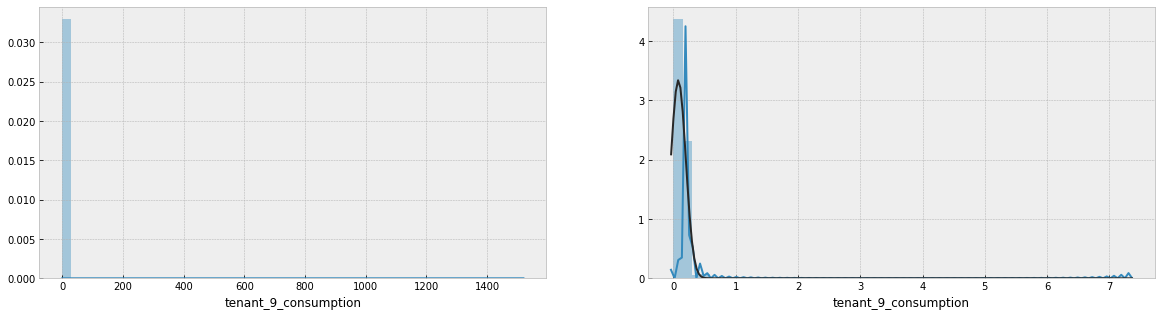

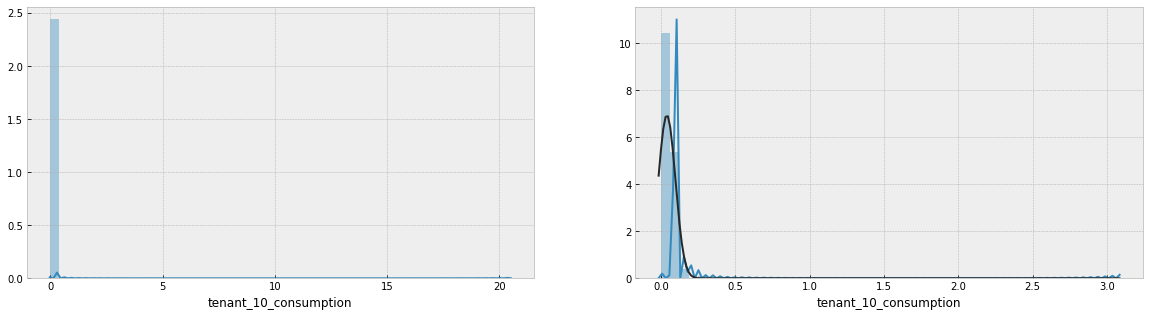

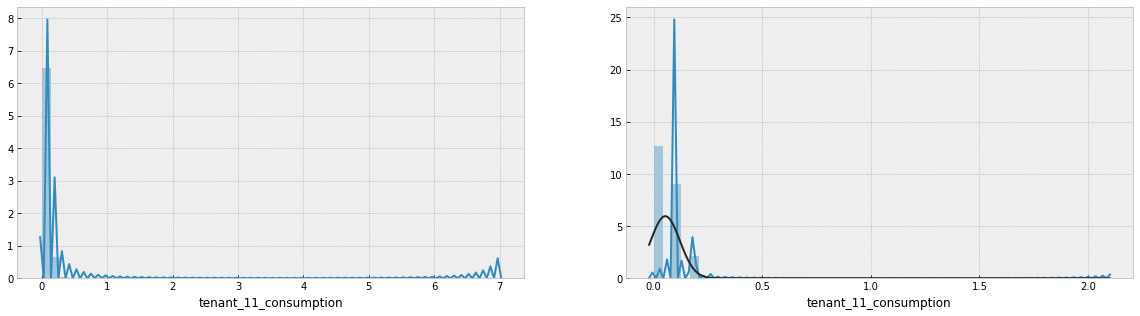

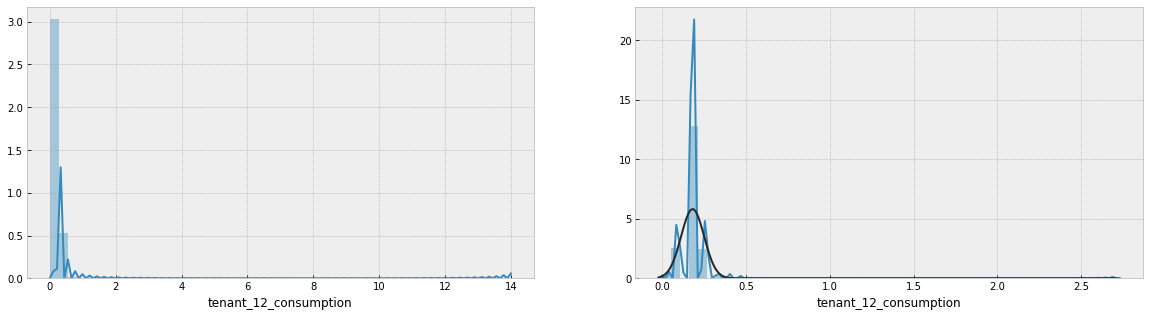

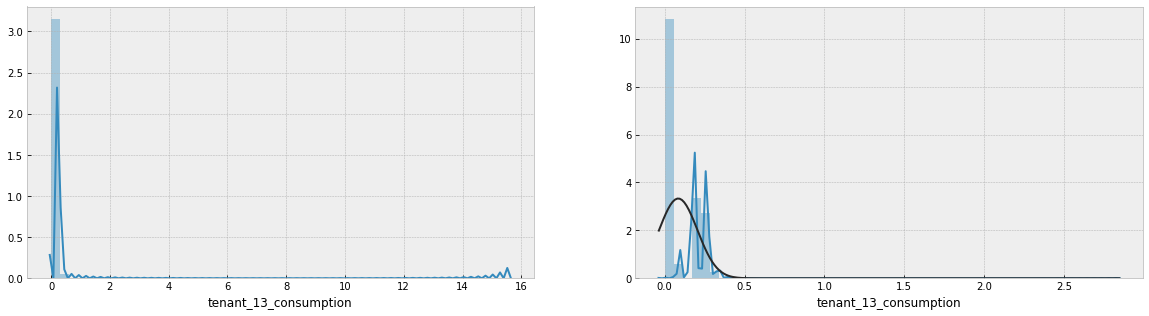

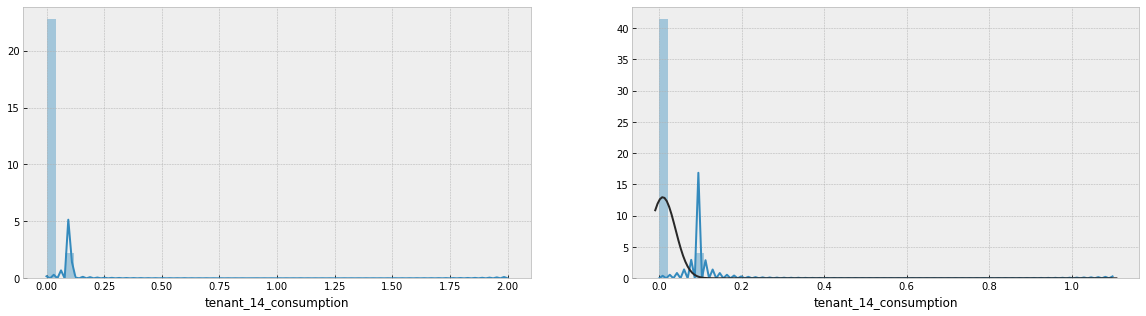

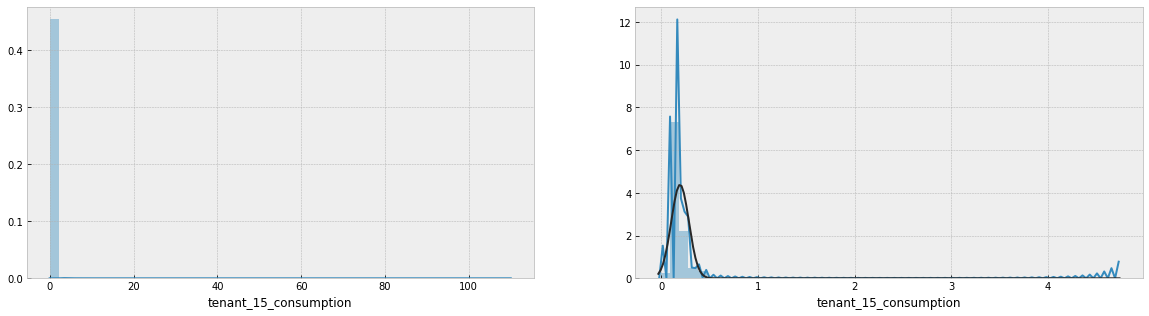

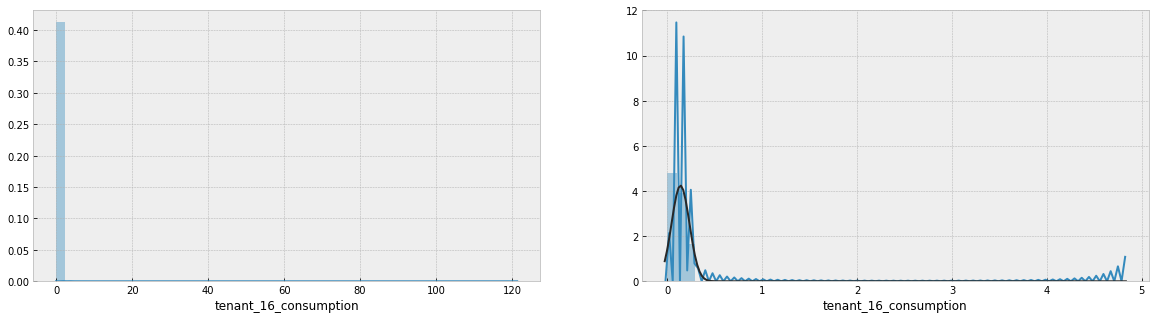

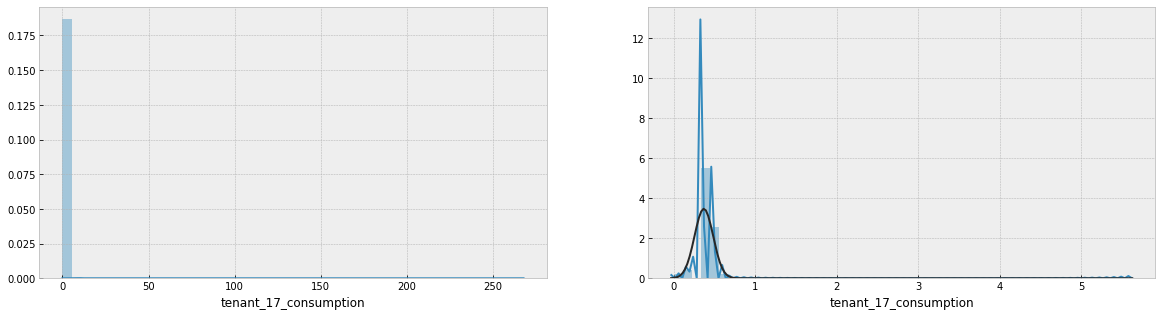

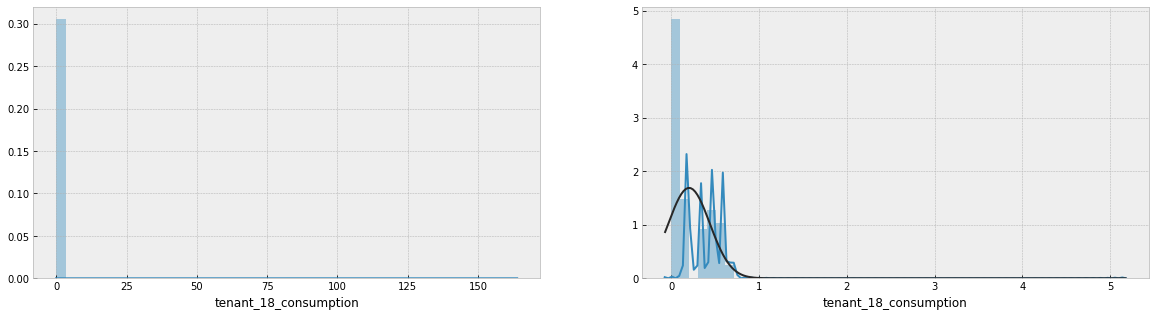

In [40]:
for i in range(1, 19):
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    sns.distplot(merge_data['tenant_'+str(i)+'_consumption'].fillna(0), ax=axs[0])
    sns.distplot(np.log1p(merge_data['tenant_'+str(i)+'_consumption'].fillna(0)), fit=norm, ax=axs[1])
    plt.show()

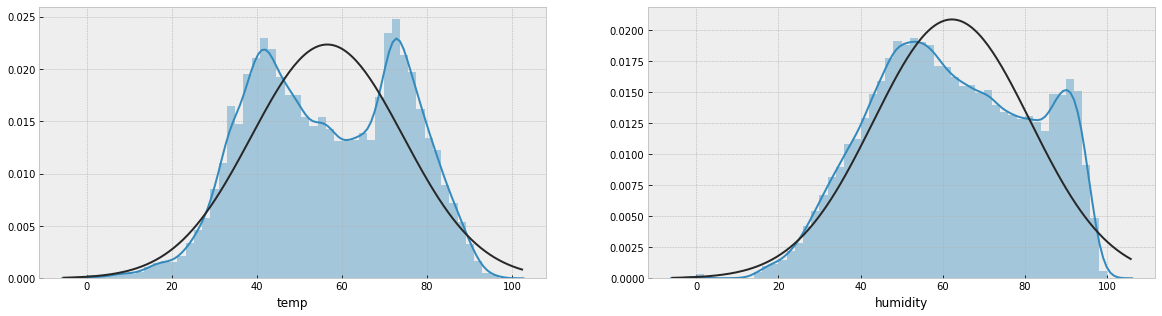

In [41]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.distplot(merge_data['temp'].fillna(0), fit=norm, ax=axs[0])
sns.distplot(merge_data['humidity'].fillna(0), fit=norm, ax=axs[1])
plt.show()

In [42]:
merge_data.to_csv('tenant_energy_clean_data.csv', index=False)

In [43]:
pd.read_csv('tenant_energy_clean_data.csv')

,date_time,electric_consumption,electric_demand,electric_cum_consumption,steam_consumption,steam_demand,temp,humidity,steam_cum_consumption,tenant_1_consumption,...,tenant_17_consumption,tenant_17_demand,tenant_17_cum_consumption,tenant_18_consumption,tenant_18_demand,tenant_18_cum_consumption,date,entries,all_tenants_consumption,all_tenants_cum_consumption
0,2018-01-01 00:15:00,430.0,1720.0,430.0,4800.0,18700.0,9.000,56.100,4800.0,0.4,...,0.2,1.2,0.2,0.0,0.0,0.0,2018-01-01 00:00:00,NaN,15.2,15.2
1,2018-01-01 00:30:00,420.0,1700.0,850.0,4480.0,18560.0,9.000,56.100,9280.0,0.4,...,0.2,0.8,0.4,0.0,0.0,0.0,2018-01-01 00:00:00,NaN,16.0,31.2
2,2018-01-01 00:45:00,440.0,1720.0,1290.0,5350.0,19660.0,9.000,56.100,14630.0,0.4,...,0.4,1.2,0.8,0.2,0.4,0.2,2018-01-01 00:00:00,NaN,15.5,46.7
3,2018-01-01 01:00:00,420.0,1720.0,1710.0,5660.0,22020.0,9.000,56.100,20290.0,0.3,...,0.4,1.6,1.2,0.0,0.4,0.2,2018-01-01 00:00:00,NaN,15.3,62.0
4,2018-01-01 01:15:00,420.0,1680.0,2130.0,5660.0,22640.0,8.975,56.125,25950.0,0.4,...,0.2,1.2,1.4,0.0,0.0,0.2,2018-01-01 00:00:00,NaN,15.3,77.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93499,2020-08-31 23:00:00,200.0,800.0,32642490.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:00:00,234.0,0.0,1360466.9
93500,2020-08-31 23:15:00,200.0,800.0,32642690.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:00:00,234.0,0.0,1360466.9
93501,2020-08-31 23:30:00,200.0,800.0,32642890.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:00:00,234.0,0.0,1360466.9
93502,2020-08-31 23:45:00,200.0,800.0,32643090.0,0.0,0.0,71.600,57.000,64226860.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:00:00,234.0,0.0,1360466.9


In [44]:
def flatten_high_points(df):
    return df

In [45]:
# time_features
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def date_time_features(date_time):
    date_time['year'] = date_time['date_time'].dt.year
    date_time['month'] = date_time['date_time'].dt.month
    date_time['day'] = date_time['date_time'].dt.day
    date_time['hour'] = date_time['date_time'].dt.hour
    date_time['minute'] = date_time['date_time'].dt.minute
    date_time['weekday'] = date_time['date_time'].dt.weekday
    date_time['is_weekend'] = date_time['date_time'].dt.weekday.apply(lambda x: 1 if x in [5,6] else 0)
    cal = calendar()
    date_time['is_holiday'] = date_time['date_time'].dt.date.astype('datetime64').isin(cal.holidays(start=date_time['date_time'].min(), end=date_time['date_time'].max())).astype(int)
    date_time['season'] = date_time['date_time'].dt.month.apply(lambda x: 'Spring' if x in [3,4,5] else \
                                                                          'Summer' if x in [6,7,8] else \
                                                                          'Fall' if x in [9,10,11] else\
                                                                          'Winter')
    date_time['daytime_range'] = date_time['date_time'].dt.hour.apply(lambda x: 'Morning' if x in [5,6,7,8,9,10] else \
                                                                               'Afternoon' if x in [11,12,13,14,15,16,17] else \
                                                                               'Evening' if x in [18,19,20,21] else
                                                                               'Night')
    return date_time

In [46]:
date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-09-01', freq='15T'), columns=['date_time'])
date_time = date_time_features(date_time)
date_time

,date_time,year,month,day,hour,minute,weekday,is_weekend,is_holiday,season,daytime_range
0,2018-01-01 00:15:00,2018,1,1,0,15,0,0,0,Winter,Night
1,2018-01-01 00:30:00,2018,1,1,0,30,0,0,0,Winter,Night
2,2018-01-01 00:45:00,2018,1,1,0,45,0,0,0,Winter,Night
3,2018-01-01 01:00:00,2018,1,1,1,0,0,0,0,Winter,Night
4,2018-01-01 01:15:00,2018,1,1,1,15,0,0,0,Winter,Night
...,...,...,...,...,...,...,...,...,...,...,...
93499,2020-08-31 23:00:00,2020,8,31,23,0,0,0,0,Summer,Night
93500,2020-08-31 23:15:00,2020,8,31,23,15,0,0,0,Summer,Night
93501,2020-08-31 23:30:00,2020,8,31,23,30,0,0,0,Summer,Night
93502,2020-08-31 23:45:00,2020,8,31,23,45,0,0,0,Summer,Night


In [47]:
cat_cols = ['year', 'month', 'day', 'hour', 'minute', 'weekday', 'is_weekend', 'is_holiday', 'season']
for col in cat_cols:
    date_time[col] = date_time[col].astype('category')
    
date_time = pd.get_dummies(date_time)
date_time.head()

,date_time,year_2018,year_2019,year_2020,month_1,month_2,month_3,month_4,month_5,month_6,...,is_holiday_0,is_holiday_1,season_Fall,season_Spring,season_Summer,season_Winter,daytime_range_Afternoon,daytime_range_Evening,daytime_range_Morning,daytime_range_Night
0,2018-01-01 00:15:00,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,2018-01-01 00:30:00,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,2018-01-01 00:45:00,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,2018-01-01 01:00:00,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,2018-01-01 01:15:00,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [48]:
def train_test(data, test_size=0.15):
    test_index = int(data.shape[0]*(1-test_size))
    tenant_cols = []
    for i in range(1,19):
        tenant_cols.extend(['tenant_'+str(i)+'_consumption', 'tenant_'+str(i)+'_cum_consumption', 'tenant_'+str(i)+'_demand'])
    X_train = data.drop(tenant_cols, axis = 1).iloc[:test_index]
    y_train = data.loc[:test_index, tenant_cols]
    X_test = data.drop(tenant_cols, axis = 1).iloc[test_index:]
    y_test = data.loc[test_index:, tenant_cols]
    
    return X_train, X_test, y_train, y_test

In [49]:
date_time.iloc[-int(date_time.shape[0]*0.15):,]

,date_time,year_2018,year_2019,year_2020,month_1,month_2,month_3,month_4,month_5,month_6,...,is_holiday_0,is_holiday_1,season_Fall,season_Spring,season_Summer,season_Winter,daytime_range_Afternoon,daytime_range_Evening,daytime_range_Morning,daytime_range_Night
79479,2020-04-07 22:00:00,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
79480,2020-04-07 22:15:00,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
79481,2020-04-07 22:30:00,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
79482,2020-04-07 22:45:00,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
79483,2020-04-07 23:00:00,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93499,2020-08-31 23:00:00,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
93500,2020-08-31 23:15:00,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
93501,2020-08-31 23:30:00,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
93502,2020-08-31 23:45:00,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
